In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import shutil

import spikeinterface.full as si

from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_selection import select_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from spikeinterface.sortingcomponents.motion import estimate_motion, interpolate_motion

from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets

In [3]:
base_folder = Path(r"D:\Data\NeuroPixel\Valo\Combined\supercat_Exp_g0")
dataset_folder = base_folder


raw_rec = si.read_spikeglx(dataset_folder)
rec = raw_rec.astype(dtype='float32')
rec

astype: 384 channels - 30.0kHz - 1 segments - 55,301,501 samples - 1,843.38s (30.72 minutes) 
        float32 dtype - 79.11 GiB

In [4]:
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

preset = 'dredge'
folder = base_folder / preset
if folder.exists():
    shutil.rmtree(folder)

In [7]:
params = si.get_motion_parameters_preset('dredge')

# Step 1 : activity profile
peaks = detect_peaks(recording=rec, **params['detect_kwargs'], **job_kwargs)


D:\software\Github\spikeinterface\src\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/1844 [00:00<?, ?it/s]

In [9]:
peak_locations = localize_peaks(recording=rec, peaks=peaks, **params['localize_peaks_kwargs'], **job_kwargs)

localize peaks using monopolar_triangulation:   0%|          | 0/1844 [00:00<?, ?it/s]

In [10]:
# Step 2: motion inference
motion = estimate_motion(recording=rec,
                         peaks=peaks,
                         peak_locations=peak_locations,
                         **params['estimate_motion_kwargs'])

In [11]:
motion_info = dict(
    parameters=dict(**params['estimate_motion_kwargs'], sampling_frequency=rec.get_sampling_frequency()),
    peaks=peaks,
    peak_locations=peak_locations,
    motion=motion,
    run_times=None,
)

if folder is not None:
    si.save_motion_info(motion_info, folder, overwrite=True)


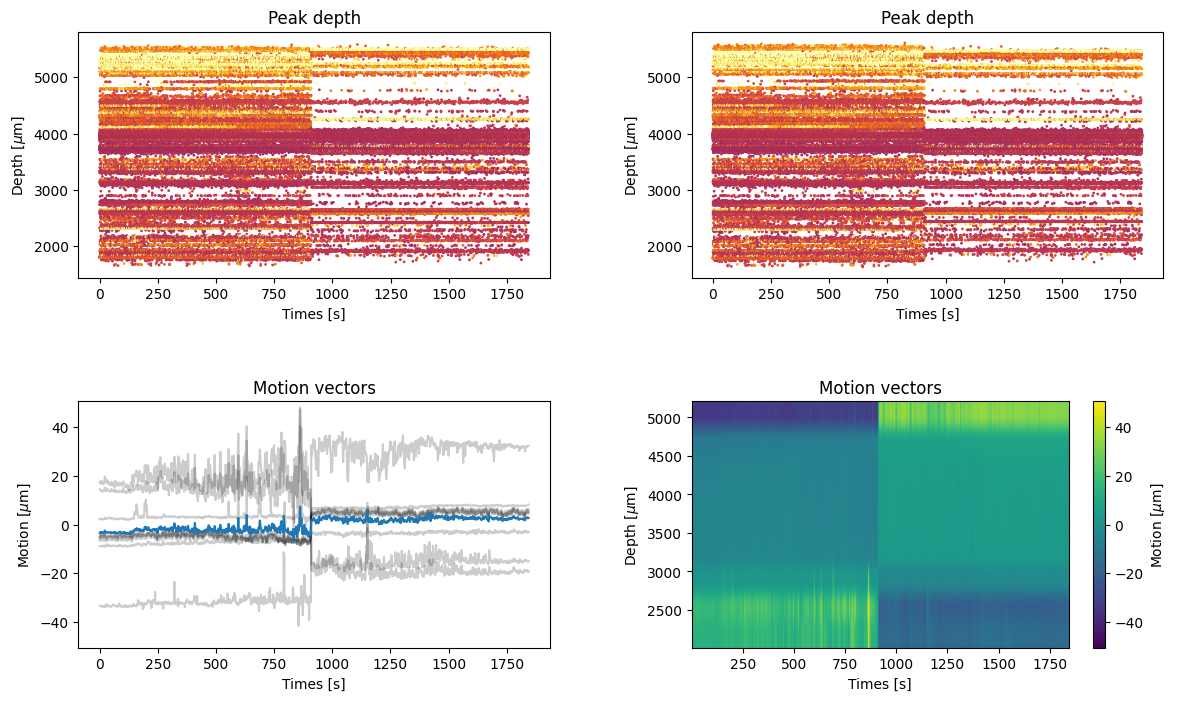

In [12]:
motion_info = si.load_motion_info(folder)

# and plot
fig = plt.figure(figsize=(14, 8))
si.plot_motion_info(
    motion_info, rec,
    figure=fig,
    color_amplitude=True,
    amplitude_cmap="inferno",
    scatter_decimate=10,
)

fig.savefig('./DredgeMotion.png')